# Trabajo práctico N° 2 - Ejercicio 1

### Descripción:

En este problema, se presenta un conjunto de datos que contiene clips de audio correspondientes a dígitos hablados del 0 al 9.
Dataset:
https://www.tensorflow.org/datasets/catalog/spoken_digit

El dataset proporcionado incluye un total de 2500 clips de audio correspondientes a 5 locutores distintos, 50 clips por dígito por locutor.

### Objetivo:

Utilizando el dataset proporcionado, el objetivo es construir un modelo de clasificación utilizando redes neuronales que pueda inferir con precisión el dígito correspondiente dado un clip de audio. Se deben entrenar y evaluar modelos utilizando técnicas adecuadas de validación y métricas de evaluación de clasificación.

Se solicita entrenar dos modelos de distintas arquitecturas y comparar los resultados:
Modelo convolucional sobre los espectrogramas de los clips.
Modelo recurrente sobre los espectrogramas de los clips.

Ver https://colab.research.google.com/github/FCEIA-AAII/lab11/blob/master/lab11-a.ipynb como ejemplo de obtención de espectrogramas a partir de clips de audio.

### Entrega:

La entrega debe incluir:
Código fuente de la solución implementada en Google Colab, que incluya:
- Análisis previo y preprocesamiento del set de datos.

- Definición y entrenamiento del modelo.

- Resultados de la evaluación de los modelos, incluyendo métricas de desempeño y visualizaciones relevantes.

Nota: el código debe estar debidamente documentado con comentarios explicativos para que el trabajo sea fácilmente comprensible para otros revisores.


## Librerias

In [113]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from IPython import display
import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras import models

In [2]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

1 Physical GPUs, 1 Logical GPUs


2025-06-09 14:09:06.042807: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:10:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-09 14:09:06.114063: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:10:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-09 14:09:06.114540: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:10:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-09 14:09:06.122122: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:10:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-09 14:09:06.122584: I tensorflow/compile

## Carga de dataset

In [94]:
df_train, df_val  = tfds.load('spoken_digit', with_info=False, as_supervised=False,shuffle_files=True,split=['train[:80%]', 'train[80%:]'])

## Análisis exploratorio

## Normalización dataset

In [95]:
def normalize_audio_length(example, target_length=8000):
    audio = example['audio']
    current_length = tf.shape(audio)[0]
    
    # Padding si es más corto
    padding_needed = tf.maximum(target_length - current_length, 0)
    audio = tf.pad(audio, [[0, padding_needed]])
    
    # Truncar si es más largo
    audio = audio[:target_length]
    
    # Mantener todas las claves originales (label, filename, etc.)
    return {
        'audio': audio,
        'label': example['label'],
        'audio/filename': example['audio/filename'],
    }

# Aplicar la normalización
df_train_norm = df_train.map(normalize_audio_length, num_parallel_calls=tf.data.AUTOTUNE)
df_val_norm = df_val.map(normalize_audio_length, num_parallel_calls=tf.data.AUTOTUNE)

# Verificar un ejemplo
for example in df_train_norm.take(1):
    print("Audio shape:", example['audio'].shape)  # Debe ser (8000,)
    print("Label:", example['label'].numpy())
    print("Filename:", example['audio/filename'].numpy().decode())

Audio shape: (8000,)
Label: 2
Filename: 2_nicolas_23.wav


2025-06-09 16:03:52.114144: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [106]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  waveform = tf.cast(waveform, tf.float32)
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [ ]:
for example_audio in df_train_norm.take(3):
    audio = tf.cast(example_audio['audio'], float)
    waveform = audio
    spectrogram = get_spectrogram(waveform)

    print('Label:', int(example_audio['label']))
    print('Waveform shape:', waveform.shape)
    print('Spectrogram shape:', spectrogram.shape)
    print('Audio playback')
    display.display(display.Audio(waveform, rate=8000))

Label: 2
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


Label: 1
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


Label: 9
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


2025-06-09 18:14:56.505267: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-06-09 18:14:56.505477: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [46]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

In [109]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda dicc: (get_spectrogram(dicc['audio']), dicc['label']),
      num_parallel_calls=tf.data.AUTOTUNE)

In [138]:
train_spectrogram_ds = make_spec_ds(df_train_norm)
val_spectrogram_ds = make_spec_ds(df_val_norm)

In [139]:
train_spectrogram_ds = train_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

## Red neuronal Convolucional

In [140]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

2025-06-09 18:31:10.669244: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [141]:
train_spectrogram_ds = train_spectrogram_ds.batch(50)
val_spectrogram_ds = val_spectrogram_ds.batch(50)

In [147]:
input_shape = example_spectrograms.shape
print('Input shape:', input_shape)
num_labels = 10

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))


model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (61, 129, 1)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_8 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_8 (Normaliza  (None, 32, 32, 1)         3         
 tion)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 conv2d_17 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)       

In [148]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [149]:
EPOCHS = 50
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
)

Epoch 1/50


2025-06-09 18:34:17.792907: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_8/dropout_16/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-06-09 18:34:18.274530: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2025-06-09 18:34:19.468905: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x770fc4d75810 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-06-09 18:34:19.469030: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 960, Compute Capability 5.2
2025-06-09 18:34:19.625626: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-09 18:34:20.396332: I ./tensorflow/compiler/jit/device_compiler.h:186] 

40/40 [==============================] - 7s 38ms/step - loss: 1.7281 - accuracy: 0.4205 - val_loss: 1.2895 - val_accuracy: 0.5980
Epoch 2/50
40/40 [==============================] - 1s 21ms/step - loss: 1.1144 - accuracy: 0.6500 - val_loss: 0.8709 - val_accuracy: 0.7680
Epoch 3/50
40/40 [==============================] - 1s 21ms/step - loss: 0.8039 - accuracy: 0.7510 - val_loss: 0.6738 - val_accuracy: 0.8260
Epoch 4/50
40/40 [==============================] - 1s 21ms/step - loss: 0.6114 - accuracy: 0.8160 - val_loss: 0.5206 - val_accuracy: 0.8800
Epoch 5/50
40/40 [==============================] - 1s 21ms/step - loss: 0.4760 - accuracy: 0.8480 - val_loss: 0.4433 - val_accuracy: 0.9120
Epoch 6/50
40/40 [==============================] - 1s 27ms/step - loss: 0.4163 - accuracy: 0.8720 - val_loss: 0.4107 - val_accuracy: 0.9160
Epoch 7/50
40/40 [==============================] - 1s 21ms/step - loss: 0.3278 - accuracy: 0.8985 - val_loss: 0.3799 - val_accuracy: 0.9200
Epoch 8/50
40/40 [======

Text(0, 0.5, 'Accuracy [%]')

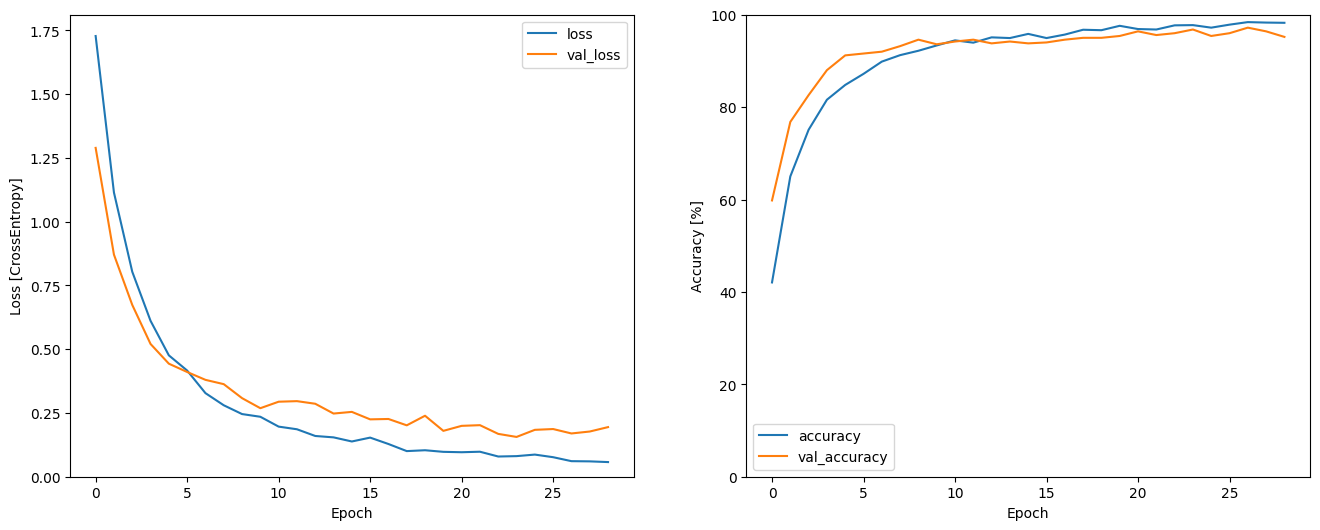

In [150]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')